## fun with [gaia-kepler.fun](http://gaia-kepler.fun)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
import astropy.coordinates as coord

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

### Load up the Kepler crossmatch data and check it out:

In [3]:
kep_data = Table.read('../scripts/kepler_dr2_4arcsec.fits', format='fits')

In [4]:
kep_data.info

<Table masked=True length=231652>
            name              dtype         unit       n_bad
---------------------------- ------- ----------------- -----
                 designation bytes28                       0
                   source_id   int64                       0
              gaia_ref_epoch float64                       0
                          ra float64               deg     0
                    ra_error float64      0.001 arcsec     0
                         dec float64               deg     0
                   dec_error float64      0.001 arcsec     0
                    parallax float64      0.001 arcsec     0
              parallax_error float64      0.001 arcsec     0
         parallax_over_error float32                       0
                        pmra float64 0.001 arcsec / yr     0
                  pmra_error float64 0.001 arcsec / yr     0
                       pmdec float64 0.001 arcsec / yr     0
                 pmdec_error float64 0.001 arcsec /

Let's calculate absolute magnitudes using the Bailer-Jones distances:

In [5]:
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['abs_gmag'].unit = u.mag

Now let's plot a color-magnitude diagram! Notice that we make some cuts to ensure that the stars are bright (G <= 18) and parallax measurements are above 0.1 mas. This is to cut out some of the less well-measured targets.

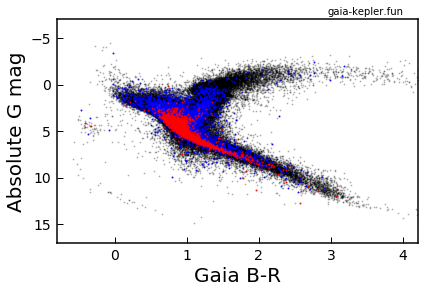

In [6]:
filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.2, color='k', s=1)
filter2 = (kep_data['planet?'] == 'cand') & filter
plt.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], alpha=0.7, s=1, color='b')
filter2 = (kep_data['planet?'] == 'conf') & filter
plt.scatter(kep_data['bp_rp'][filter2], kep_data['abs_gmag'][filter2], alpha=0.7, s=1, color='r')
plt.xlabel('Gaia B-R', fontsize=20)
plt.ylabel('Absolute G mag', fontsize=20)
plt.ylim([17,-7])
plt.xlim([-0.8,4.2])
plt.text(0.75,1.02,'gaia-kepler.fun', transform=plt.gca().transAxes)
#ax = plt.gca()
#ax.set_aspect(5/24.)
plt.tight_layout()
plt.savefig('../img/colormag_kepler.png')

(The above code makes candidate planet host stars blue and confirmed planet host stars red.)

In [7]:
from bokeh.plotting import *
from bokeh.io import output_notebook
from bokeh.models import OpenURL, Circle, HoverTool, PanTool, BoxZoomTool, ResetTool, SaveTool, TapTool, WheelZoomTool

In [8]:
output_notebook()

Loading BokehJS ...

In [9]:
filter2 = (kep_data['planet?'] == 'conf') & filter

source = ColumnDataSource(
    data=dict(
        kepid=kep_data[filter2]['kepid'].data.data,
        kepmag=kep_data[filter2]['kepmag'].data.data,
        bp_rp=kep_data[filter2]['bp_rp'].data.data,
        abs_gmag=kep_data[filter2]['abs_gmag'].data.data,
        mass=kep_data[filter2]['mass'].data.data,
        radius=kep_data[filter2]['radius'].data.data
        )
    ) 

In [10]:
#output_file('bokeh_kepler_cmd.html')
fig = figure(tools="pan,wheel_zoom,box_zoom,reset", x_range=[-0.8,4.2],
        y_range=[17,-7], active_scroll="wheel_zoom")   
kep_render = fig.circle('bp_rp','abs_gmag', source=source, size=10, name='KICs')
hover = HoverTool(renderers=[kep_render],
                    tooltips=[
        ("kepid", "@kepid"),
        ("kepmag", "@kepmag"),
        ("mass", "@mass"),
        ("radius", "@radius"),
        ]
    )
fig.add_tools(hover)

fig.xaxis.axis_label = 'Gaia Bp-Rp (mag)'
fig.yaxis.axis_label = 'Gaia Abs. G Mag'
fig.xaxis.axis_label_text_font_size = '14pt'
fig.xaxis.major_label_text_font_size = '12pt'
fig.yaxis.axis_label_text_font_size = '14pt'   
fig.yaxis.major_label_text_font_size = '12pt' 
#save(fig)
show(fig)

### Now we'll do the same for K2!

In [11]:
k2_data = Table.read('../scripts/k2_dr2_1arcsec.fits', format='fits')

In [12]:
k2_data['abs_gmag'] = k2_data['phot_g_mean_mag'] - \
                            5.*(np.log10(k2_data['r_est']) - 1.)
k2_data['abs_gmag'].unit = u.mag

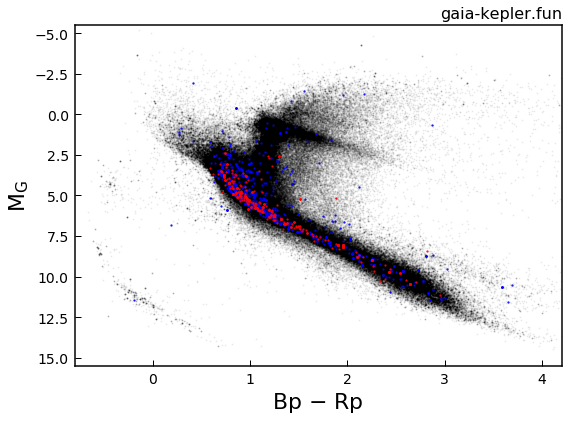

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
filter = (k2_data['phot_g_mean_mag'] <= 18.) & (k2_data['parallax'] > 0.1)
plt.scatter(k2_data['bp_rp'][filter], k2_data['abs_gmag'][filter], alpha=0.05, color='k', s=1)
filter2 = (k2_data['k2c_disp'] == 'CANDIDATE') & filter
plt.scatter(k2_data['bp_rp'][filter2], k2_data['abs_gmag'][filter2], alpha=0.7, s=2, color='b')
filter2 = (k2_data['k2c_disp'] == 'CONFIRMED') & filter
plt.scatter(k2_data['bp_rp'][filter2], k2_data['abs_gmag'][filter2], alpha=0.7, s=2, color='r')
plt.xlabel(r'Bp $-$ Rp', fontsize=22)
plt.ylabel(r'M$_{\mathrm{G}}$', fontsize=22)
plt.ylim([15.5,-5.5])
plt.xlim([-0.8,4.2])
plt.text(0.75,1.02,'gaia-kepler.fun', fontsize=16, transform=plt.gca().transAxes)
ax = plt.gca()
ax.set_aspect(5/30.)
plt.tight_layout()
plt.savefig('../img/colormag_k2.png')

In [14]:
filter2 = (k2_data['k2c_disp'] == 'CANDIDATE') & filter

source = ColumnDataSource(
    data=dict(
        kepid=k2_data[filter2]['epic_number'].data.data,
        bp_rp=k2_data[filter2]['bp_rp'].data.data,
        abs_gmag=k2_data[filter2]['abs_gmag'].data.data,
        k2_mass=k2_data[filter2]['k2_mass'].data.data,
        k2_radius=k2_data[filter2]['k2_rad'].data.data,
        gaia_radius=k2_data[filter2]['radius_val'].data.data,
        gaia_teff=k2_data[filter2]['teff_val'].data.data
        )
    ) 

In [15]:
k2_data[k2_data['epic_number'] == 210605073]

designation,source_id,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,phot_variable_flag,l,b,ecl_lon,ecl_lat,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,epic_number,ra_epic,dec_epic,r_est,r_lo,r_hi,r_length_prior,r_result_flag,r_modality_flag,tm_name,k2_campaign_str,k2_type,k2_lcflag,k2_scflag,k2_teff,k2_tefferr1,k2_tefferr2,k2_logg,k2_loggerr1,k2_loggerr2,k2_metfe,k2_metfeerr1,k2_metfeerr2,k2_rad,k2_raderr1,k2_raderr2,k2_mass,k2_masserr1,k2_masserr2,k2_kepmag,k2_kepmagerr,k2_kepmagflag,k2c_disp,k2c_note,k2_gaia_ang_dist,abs_gmag
,,,deg,0.001 arcsec,deg,0.001 arcsec,0.001 arcsec,0.001 arcsec,,0.001 arcsec / yr,0.001 arcsec / yr,0.001 arcsec / yr,0.001 arcsec / yr,,,,,,,,,,,,mas,,,,ph / s,ph / s,mag,ph / s,ph / s,mag,ph / s,ph / s,mag,mag,mag,mag,km / s,km / s,,deg,deg,deg,deg,K,K,K,mag,mag,mag,mag,mag,mag,solRad,solRad,solRad,solLum,solLum,solLum,,deg,deg,pc,pc,pc,pc,,,,,,,,K,K,K,,,,,,,solRad,solRad,solRad,solMass,solMass,solMass,,,,,,arcsec,mag
bytes28,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,bool,bool,float64,float64,float32,float64,float64,float32,float64,float64,float32,float32,float32,float32,float64,float64,bytes13,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64,float64,float64,float64,float64,int16,int16,bytes25,bytes2,bytes8,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,bytes14,bytes59,float64,float64
Gaia DR2 3313865034653166208,3313865034653166208,2015.5,65.62328600125016,0.17412703727210105,17.037876834908996,0.08955950821560842,0.49971884310782133,0.18878888796792312,2.6469717,1.0386459255598306,0.340549594666483,-3.56797357301972,0.2525865094634004,0.28546405,0.45301133,-0.2326739,0.19511841,0.22743607,0.08616876,-0.4446057,0.16426629,0.22535738,0.14451668,307.67792,0.13341977410740427,0.20139640483874185,False,False,1352.487773427087,1.810051426236373,17.860533,968.7695004611774,7.529131446641557,17.885838,668.1760087676337,6.2536486898037476,17.699694,0.18614388,0.025304794,0.16083908,0.0,nan,NOT_AVAILABLE,178.35965924625003,-22.413807216440883,66.68332103656151,-4.4499627794216545,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,210605073,65.62329,17.037875,1629.15315391164,1259.13156180622,2210.53942064763,470.100006490651,1,1,N/A,4,STAR,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.887,--,gri,CANDIDATE,N/A,0.06873527718283538,6.8007231930610565


In [16]:
output_file('bokeh_k2_cmd.html')
fig = figure(tools="pan,wheel_zoom,box_zoom,reset", x_range=[-0.8,4.2],
        y_range=[17,-7], active_scroll="wheel_zoom")   
kep_render = fig.circle('bp_rp','abs_gmag', source=source, size=10, name='EPICs')
hover = HoverTool(renderers=[kep_render],
                    tooltips=[
        ("EPIC", "@kepid"),
        ("K2 mass", "@k2_mass"),
        ("K2 radius", "@k2_radius"),
        ("Gaia radius", "@gaia_radius"),
        ("Gaia Teff", "@gaia_teff")
        ]
    )
fig.add_tools(hover)
save(fig)

'/Users/mbedell/Documents/Web Design/gaia-kepler.fun/notebooks/bokeh_k2_cmd.html'

### Fun with proper motions:

In [7]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import animation
from IPython.display import HTML
from astropy.time import Time

Filter out the poorly measured stars:

In [8]:
filter = (kep_data['phot_g_mean_mag'] >= 18.) & (kep_data['parallax'] > 0.01)
tab = kep_data[filter]

In [9]:
gaia_time = Time('2015-01-01')
tab['radial_velocity'][np.isnan(tab['radial_velocity'])] = 0.

(We have to zero out the non-measured RVs because otherwise astropy NaNs everything...)

Let's inflate the PMs, RVs, and parallaxes so they're visible, and bring the stars closer to us:

In [10]:
amplitude = 1e5
tab['radial_velocity'] *= amplitude
tab['pmra'] *= amplitude
tab['pmdec'] *= amplitude
tab['parallax'] *= amplitude
tab['r_est'] /= amplitude

Make SkyCoord objects with astropy. This will allow us to easily calculate the stars' positions at different dates (but it doesn't like dates like JD = 500000, which is why we had to artificially inflate the motions for what we'll do below).

In [11]:
scnow = SkyCoord(ra=tab['ra'], dec=tab['dec'], 
                 distance=tab['r_est'],
                 radial_velocity=tab['radial_velocity'],
                 pm_ra_cosdec=tab['pmra'], 
                 pm_dec=tab['pmdec'], obstime=gaia_time
                )
mag = tab['phot_g_mean_mag']

Function that moves all stars forward or backward by "t" years and plots them:

In [19]:
def animfunc(t, xlim, ylim, ax, cbar):
    sclater = scnow.apply_space_motion(new_obstime=gaia_time + t * u.yr)
    
#    if cbar is not None:
#        cbar.remove()
    ax.cla()
    ax.set_title('Kepler field, T={:,.0f} years'.format(t*amplitude), fontsize=18)
    s = ax.scatter(sclater.ra.deg, sclater.dec.deg, c=np.log10(sclater.distance.value), 
               **scatkwargs)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Right Ascension (degrees)', fontsize=16)
    ax.set_xlabel('Declination (degrees)', fontsize=16)
    ax.grid(alpha=.5)
#    cbar = fig.colorbar(s, ax=ax, ticks=[1,2,3,4])
#    cbar.ax.set_yticklabels(['0.01', '0.1', '1', '10'])  # vertically oriented colorbar
#    cbar.set_label('Distance (kpc)', rotation=270, fontsize=16)

matplotlib animation:

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot()
cbar = None

scatkwargs = dict(alpha=.6, s=2, cmap='viridis', vmin=2., vmax=4.)

times = np.linspace(-5., 0., 51)
times = np.append(times, np.zeros(20))
times = np.append(times, np.linspace(0., 5., 51))

anim1 = animation.FuncAnimation(fig, animfunc, times,
                                fargs=([275,305], [33,55], ax, cbar), 
                                interval=50)

#cbar = fig.colorbar(s, ax=ax, ticks=[2,3,4])
#cbar.ax.set_yticklabels(['0.1', '1', '10'])  # vertically oriented colorbar
#cbar.set_label('Distance (kpc)', rotation=270, fontsize=16)

plt.close(fig)
HTML(anim1.to_html5_video())

In [23]:
anim1.save('kepler_propermotions.mp4', dpi=80, writer='imagemagick')